In [4]:
%%capture
%%bash

pip install --upgrade scipy flax
pip install --upgrade "jax[cuda]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
pip install --upgrade diffusers transformers

In [5]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` now requires a token generated from https://huggingface.co/settings/tokens .
    
Token: 
Add token as git credential? (Y/n) n
Token is valid.
Your token has been saved to /root/.huggingface/token
Login successful


In [6]:
import jax
import jax.numpy as jnp
import numpy as np
from flax.jax_utils import replicate
from flax.training.common_utils import shard

import matplotlib.pyplot as plt
%matplotlib inline

from transformers import CLIPTextModel, CLIPTokenizer

In [7]:
from transformers import CLIPFeatureExtractor, CLIPTokenizer, FlaxCLIPTextModel

In [8]:
from diffusers import FlaxAutoencoderKL, FlaxUNet2DConditionModel

In [9]:
from diffusers import (
    FlaxDDIMScheduler,
    FlaxDPMSolverMultistepScheduler,
    FlaxLMSDiscreteScheduler,
    FlaxPNDMScheduler,
)

```
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16)
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16).to("cuda")
```

`jax.numpy.float16` (on GPUs) and `jax.numpy.bfloat16` (on TPUs)

In [10]:
dtype = jax.numpy.float16

 [Flax] Add DreamBooth #1001 https://github.com/huggingface/diffusers/pull/1001 `duongna/stable-diffusion-v1-4-flax`

In [11]:
model_id = "CompVis/stable-diffusion-v1-4"

In [12]:
tokenizer = CLIPTokenizer.from_pretrained(model_id, revision="flax", subfolder="tokenizer", dtype=dtype)
text_encoder = FlaxCLIPTextModel.from_pretrained(model_id, revision="flax", subfolder="text_encoder", dtype=dtype)

Downloading:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/472 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/806 [00:00<?, ?B/s]

ftfy or spacy is not installed using BERT BasicTokenizer instead of ftfy.


Downloading:   0%|          | 0.00/592 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/492M [00:00<?, ?B/s]

In [13]:
vae, vae_params = FlaxAutoencoderKL.from_pretrained(model_id, revision="flax", subfolder="vae", dtype=dtype)
unet, unet_params = FlaxUNet2DConditionModel.from_pretrained(model_id, revision="flax", subfolder="unet", dtype=dtype)

/usr/local/lib/python3.7/dist-packages/diffusers/utils/deprecation_utils.py:35: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.
  warnings.warn(warning + message, FutureWarning)


Downloading:   0%|          | 0.00/522 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/335M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/diffusers/utils/deprecation_utils.py:35: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a model, please use <class 'diffusers.models.unet_2d_condition_flax.FlaxUNet2DConditionModel'>.load_config(...) followed by <class 'diffusers.models.unet_2d_condition_flax.FlaxUNet2DConditionModel'>.from_config(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  warnings.warn(warning + message, FutureWarning)


Downloading:   0%|          | 0.00/743 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

```
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
text_input['input_ids']
```

In [43]:
scheduler, scheduler_params = FlaxPNDMScheduler.from_pretrained(model_id, revision="flax", subfolder="scheduler")

In [19]:
prompt = "a photo of an astronaut riding a horse on mars"

In [20]:
token_ids = tokenizer.encode(prompt)

In [21]:
token_ids

[49406, 320, 1125, 539, 550, 18376, 6765, 320, 4558, 525, 7496, 49407]

In [22]:
tokenizer.decode(49406), tokenizer.decode(49407)

('<|startoftext|>', '<|endoftext|>')

In [23]:
text_input = tokenizer(
            prompt,
            padding="max_length",
            max_length=tokenizer.model_max_length,
            truncation=True,
            return_tensors="np",
        )

In [24]:
text_input.input_ids

array([[49406,   320,  1125,   539,   550, 18376,  6765,   320,  4558,
          525,  7496, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407]])

```
text_embeddings = text_encoder(text_input.input_ids.to("cuda"))[0].half()
text_embeddings.shape
```

In [25]:
# get prompt text embeddings
text_embeddings = text_encoder(text_input.input_ids)[0]

In [26]:
"DEBUG", text_embeddings.shape

('DEBUG', (1, 77, 768))

In [27]:
batch_size, max_length = text_input.input_ids.shape[0], text_input.input_ids.shape[-1]
vae_scale_factor = 2 ** (len(vae.config.block_out_channels) - 1)

In [28]:
"DEBUG", batch_size, max_length, vae_scale_factor

('DEBUG', 1, 77, 8)

In [29]:
uncond_input = tokenizer(
    [""] * batch_size,
    padding="max_length",
    max_length=max_length,
    return_tensors="np"
)

uncond_input = uncond_input.input_ids

In [30]:
uncond_embeddings = text_encoder(uncond_input)[0]

In [31]:
"DEBUG", uncond_embeddings.shape

('DEBUG', (1, 77, 768))

In [32]:
context = jnp.concatenate([uncond_embeddings, text_embeddings])

In [33]:
"DEBUG", context.shape

('DEBUG', (2, 77, 768))

In [34]:
height = unet.config.sample_size * vae_scale_factor
width = unet.config.sample_size * vae_scale_factor

latents_shape = (
            batch_size,
            unet.in_channels,
            height // vae_scale_factor,
            width // vae_scale_factor,
        )

prng_seed = jax.random.PRNGKey(0)

In [35]:
"DEBUG", height, width, latents_shape, prng_seed

('DEBUG', 512, 512, (1, 4, 64, 64), DeviceArray([0, 0], dtype=uint32))

In [36]:
latents = jax.random.normal(prng_seed, shape=latents_shape, dtype=dtype)

In [37]:
"DEBUG", latents.shape

('DEBUG', (1, 4, 64, 64))

In [38]:
guidance_scale = 7.5 #@param {type:"slider", min:0, max:100, step:0.5}
num_inference_steps = 30 #@param

In [39]:
from diffusers.schedulers.scheduling_pndm_flax import PNDMSchedulerState
import pdb

In [41]:
def diffusion_loop(step, args):
    latents, scheduler_state = args
    # For classifier free guidance, we need to do two forward passes.
    # Here we concatenate the unconditional and text embeddings into a single batch
    # to avoid doing two forward passes
    latents_input = jnp.concatenate([latents] * 2)

    t = jnp.array(scheduler_state.timesteps, dtype=jnp.int32)[step]
    timestep = jnp.broadcast_to(t, latents_input.shape[0])

    latents_input = scheduler.scale_model_input(scheduler_state, latents_input, t)

    # predict the noise residual
    noise_pred = unet.apply(
        {"params": unet_params},
        jnp.array(latents_input),
        jnp.array(timestep, dtype=jnp.int32),
        encoder_hidden_states=context,
        ).sample
    # perform guidance
    noise_pred_uncond, noise_prediction_text = jnp.split(noise_pred, 2, axis=0)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_prediction_text - noise_pred_uncond)

    # compute the previous noisy sample x_t -> x_t-1
    # run(state=scheduler_state, model_output=noise_pred, sample=latents)
    
    latents, scheduler_state = scheduler.step(scheduler_state, noise_pred, t, latents).to_tuple()
    return latents, scheduler_state


In [44]:
scheduler_state = scheduler.set_timesteps(
    scheduler_params, num_inference_steps=num_inference_steps, shape=latents.shape
    )

In [52]:
scheduler_state.timesteps

DeviceArray([958, 925, 925, 892, 859, 826, 793, 760, 727, 694, 661, 628,
             595, 562, 529, 496, 463, 430, 397, 364, 331, 298, 265, 232,
             199, 166, 133, 100,  67,  34,   1], dtype=int32)

In [45]:
# scale the initial noise by the standard deviation required by the scheduler
latents = latents * scheduler.init_noise_sigma

In [46]:
"DEBUG", latents.shape

('DEBUG', (1, 4, 64, 64))

```
# run with python for loop
for i in range(num_inference_steps):
    latents, scheduler_state = diffusion_loop(i, (latents, scheduler_state))
```

```
# run with Jax loop (much faster)
latents, _ = jax.lax.fori_loop(0, num_inference_steps, diffusion_loop, (latents, scheduler_state))
```

In [47]:
latents, _ = jax.lax.fori_loop(0, num_inference_steps, diffusion_loop, (latents, scheduler_state))

TypeError: ignored

In [45]:
# scale and decode the image latents with vae
latents = 1 / 0.18215 * latents
image = vae.apply({"params": vae_params}, latents, method=vae.decode).sample

image = (image / 2 + 0.5).clip(0, 1).transpose(0, 2, 3, 1)

In [3]:
from diffusers import FlaxDiffusionPipeline

ModuleNotFoundError: ignored

```
images = FlaxDiffusionPipeline.numpy_to_pil(np.asarray(images.reshape((num_samples,) + images.shape[-3:])))
```

In [47]:
images = image
images = FlaxDiffusionPipeline.numpy_to_pil(np.asarray(images.reshape((1,) + images.shape[-3:])))

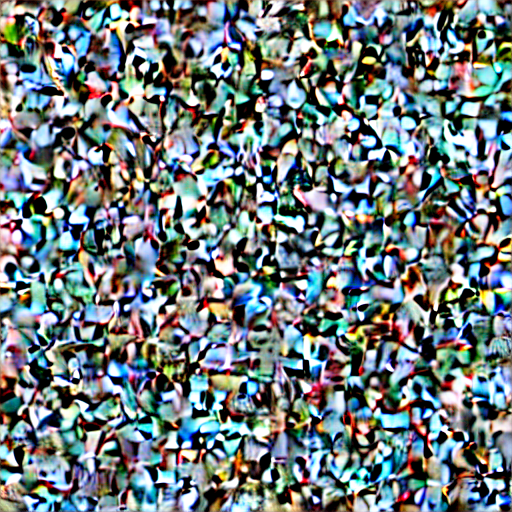

In [48]:
images[0]

## Noise scheduling

```
scheduler = LMSDiscreteScheduler(beta_start=beta_start, beta_end=beta_end, beta_schedule="scaled_linear", num_train_timesteps=1000)
```

In [55]:
scheduler = FlaxLMSDiscreteScheduler(
    beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000
)

In [57]:
scheduler.create_state()

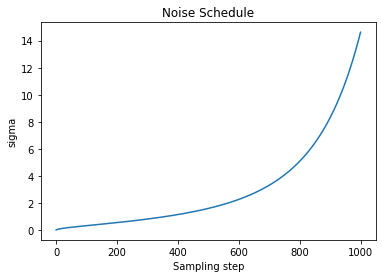

In [ ]:
# Plotting this noise schedule:
plt.plot(scheduler.state.sigmas)
plt.title('Noise Schedule')
plt.xlabel('Sampling step')
plt.ylabel('sigma')
plt.show()